After merging the given datasets, I was able to wrangle the data by reducing repetitive entries and columns that had too much missing information. Thereafter, I created a Train-Test split to then form a Logistic Regression and Data Tree  Model. Once I checked the metrics, I took the Data Tree Model onto wrangle the Test Group and created my prediction column for the Water Pump Challenge.

In [1]:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
    !pip install pdpbox
    !pip install shap

  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 2.13.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import category_encoders as ce
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [6]:
%cd /content/gdrive/MyDrive/Kaggle
!ls

/content/gdrive/MyDrive/Kaggle
model_rf_Water_Pump		   sample_submission.csv  train_features.csv
OTTOLINO_WATER_PUMP_CHALLENGE.csv  test_features.csv	  train_labels.csv


In [7]:
train_features = pd.read_csv('train_features.csv')


In [8]:
train_labels = pd.read_csv('train_labels.csv')

In [9]:
train = pd.merge(pd.read_csv('train_features.csv'),pd.read_csv('train_labels.csv'))
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
3,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
4,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,68525,1000.0,2011-03-20,Dhv,327,DWE,36.367112,-8.774761,Kwa Mbayambaya,0,Rufiji,Bwawani,Morogoro,5,4,Ulanga,Mtimbira,255,True,GeoData Consultants Ltd,Water Board,Mtimbira,True,1995,gravity,gravity,gravity,wug,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
47516,11980,1000.0,2011-03-10,Danida,1743,DANID,34.531524,-9.769604,none,0,Lake Nyasa,Mlangali Ndani,Iringa,11,5,Ludewa,Mlangali,35,True,GeoData Consultants Ltd,VWC,DANIDA,False,1988,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,seasonal,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional
47517,35778,0.0,2011-03-13,Omar Ally,-13,Omar Ally,38.974416,-5.420823,Kwa Omar Ally,0,Pangani,Sokoni,Tanga,4,5,Pangani,Pangani Mashariki,1000,False,GeoData Consultants Ltd,Private operator,NaN,False,2005,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
47518,49444,0.0,2012-10-31,Rwssp,0,WEDECO,34.316586,-3.107161,Muungano,0,Lake Victoria,Ijosho,Shinyanga,17,6,Meatu,Sakasaka,0,True,GeoData Consultants Ltd,WUG,None,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [10]:
train.shape

(47520, 41)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 0 to 47519
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47520 non-null  int64  
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44644 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44631 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47224 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15  lg

In [12]:
#Report = ProfileReport(train, minimal=True).to_notebook_iframe()

In [73]:
train = pd.merge(pd.read_csv('train_features.csv', na_values=[0,-2.000000e-08],
                              parse_dates=['date_recorded']),
                 pd.read_csv('train_labels.csv', na_values=[0,-2.000000e-08]))

In [74]:
drop_col = ['basin','region_code',	'district_code', 'quantity_group','source_type','source_class','extraction_type_group','extraction_type_class','management_group','payment_type','waterpoint_type_group','quality_group','scheme_management','num_private','amount_tsh']

In [109]:
def wrangle(df):

  df = pd.merge(pd.read_csv('train_features.csv', 
                            na_values=[0,-2.000000e-08],
                            parse_dates=['date_recorded']),
                 pd.read_csv('train_labels.csv', 
                            na_values=[0,-2.000000e-08]))
  
#turn id to float due to kaggle error
  df['id'].astype(float)
#make 'id' index
  df.set_index('id', inplace=True)

#Turn 'status_group' into binary classification
  df['status_group'] = np.where(df['status_group'] == 'functional', 0, 1)

#Engineer new target column
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']

# Extract components from date_recorded, then drop the original column
  df['year_recorded'] = df.date_recorded.dt.year
  df['month_recorded'] = df.date_recorded.dt.month
  df['day_recorded'] = df.date_recorded.dt.day

#Drop datetime column
  df.drop(columns=['date_recorded'],inplace=True)
  
#Constant columns will not help our model  
  constant_columns = [col for col in df.columns if df[col].nunique() ==1]
  df = df.drop(columns=constant_columns)

# Drop HCCs
  threshold = 100
  drop_hcc = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > threshold]
  df.drop(columns=drop_hcc, inplace=True)

#self-inspection to drop duplicate columns seemed to be more accurate
  df.drop(columns=drop_col, inplace=True)

#reexplore this drop due to too many NaNs
  df.drop(columns=['gps_height'],inplace=True)
  
#Turn string classification targets into binary classification
  df['public_meeting'] = df['public_meeting'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)
  df['permit'] = df['permit'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)
  #df['longitude_missing'] = df['longitude_missing'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)
  #df['latitude_missing'] = df['latitude_missing'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)
  #df['construction_year_missing'] = df['construction_year_missing'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)
  #df['years_missing'] = df['years_missing'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)

#replace the zeros with nulls
  cols_with_zeros = ['longitude', 'latitude', 'construction_year']
  for col in cols_with_zeros:
      df[col] = df[col].replace(0, np.nan)

#change numerical NaNs to mean
  df['pump_age'] = df['pump_age'].fillna(df.mean())
  df['construction_year'] = df['construction_year'].fillna(df.mean())
  df['permit'] = df['permit'].fillna(df.mean())
  df['public_meeting'] = df['public_meeting'].fillna(df.mean())
  df['population'] = df['population'].fillna(df.mean())
  df['latitude'] = df['latitude'].fillna(df.mean())
  df['longitude'] = df['longitude'].fillna(df.mean())
                 

  return df

train = wrangle(train)
test = wrangle('https://raw.githubusercontent.com/JuliaOttolino/WATER_PUMP_KAGGLE_CHALLENGE/main/test_features.csv')

train.shape




(47520, 19)

In [111]:
train.isnull().sum()

longitude             1433
latitude              1433
region                   0
population           17048
public_meeting        2689
permit                2439
construction_year    16503
extraction_type          0
management               0
payment                  0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
status_group             0
pump_age             16503
year_recorded            0
month_recorded           0
day_recorded             0
dtype: int64

In [112]:
train['permit'].value_counts()

1.0    31028
0.0    14053
Name: permit, dtype: int64

In [113]:
train

,longitude,latitude,region,population,public_meeting,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,pump_age,year_recorded,month_recorded,day_recorded
id,,,,,,,,,,,,,,,,,,,
454.0,35.426020,-4.227446,Manyara,160.0,1.0,1.0,1998.0,gravity,water board,pay per bucket,soft,insufficient,spring,communal standpipe,0,15.0,2013,2,27
510.0,35.510074,-5.724555,Dodoma,NaN,1.0,1.0,NaN,india mark ii,vwc,never pay,soft,enough,shallow well,hand pump,0,NaN,2011,3,17
14146.0,32.499866,-9.081222,Mbeya,NaN,1.0,0.0,NaN,other,vwc,never pay,soft,enough,shallow well,other,1,NaN,2011,7,10
47410.0,34.060484,-8.830208,Mbeya,NaN,1.0,1.0,NaN,gravity,vwc,pay monthly,soft,insufficient,river,communal standpipe,1,NaN,2011,4,12
1288.0,37.032690,-6.040787,Morogoro,120.0,1.0,1.0,1997.0,other,vwc,pay when scheme fails,salty,enough,shallow well,other,1,14.0,2011,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525.0,36.367112,-8.774761,Morogoro,255.0,1.0,1.0,1995.0,gravity,wug,pay monthly,soft,enough,river,communal standpipe,0,16.0,2011,3,20
11980.0,34.531524,-9.769604,Iringa,35.0,1.0,0.0,1988.0,gravity,vwc,pay annually,soft,seasonal,spring,communal standpipe,0,23.0,2011,3,10
35778.0,38.974416,-5.420823,Tanga,1000.0,0.0,0.0,2005.0,other,private operator,never pay,soft,insufficient,shallow well,other,1,6.0,2011,3,13


In [114]:
#train.isnull().sum()

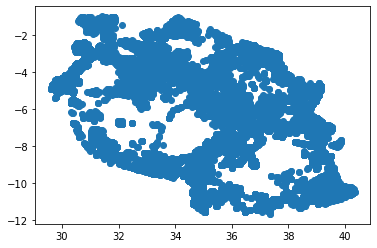

In [115]:
plt.scatter(train['longitude'],train['latitude'])
plt.show()

In [116]:
train['status_group'].value_counts()

0    25802
1    21718
Name: status_group, dtype: int64

In [117]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)
X_test = test.drop(columns=target)

In [118]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.5, random_state=42)

In [119]:
print('BASELINE ACCURACY:', y_train.value_counts(normalize=True).max() )

BASELINE ACCURACY: 0.5472643097643097


In [120]:
train.dtypes

longitude            float64
latitude             float64
region                object
population           float64
public_meeting       float64
permit               float64
construction_year    float64
extraction_type       object
management            object
payment               object
water_quality         object
quantity              object
source                object
waterpoint_type       object
status_group           int64
pump_age             float64
year_recorded          int64
month_recorded         int64
day_recorded           int64
dtype: object

In [121]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression())

model_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['region', 'extraction_type', 'management',
                                     'payment', 'water_quality', 'quantity',
                                     'source', 'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_v...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_i

In [122]:
print('model_lr accuracy score for training', accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val', accuracy_score(y_val, model_lr.predict(X_val)))

#before futher column drops
#model_lr accuracy score for training 0.7507154882154882
#model_lr accuracy score for val 0.751473063973064

model_lr accuracy score for training 0.7524410774410775
model_lr accuracy score for val 0.7517255892255892


In [123]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100,
                           max_depth = 15,
                           n_jobs=-1,
                           random_state=42)
)

model_rf.fit(X_train, y_train);

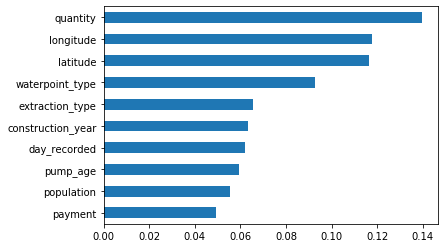

In [124]:
importances = model_rf.named_steps.randomforestclassifier.feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

In [125]:
print('Training Accuracy:', model_rf.score(X_train, y_train))
print('Validation Accuracy:', model_rf.score(X_val, y_val))

#before NaN fix
#Training Accuracy: 0.9334595959595959
#Validation Accuracy: 0.8074074074074075

Training Accuracy: 0.934469696969697
Validation Accuracy: 0.8072390572390572


In [126]:
# save model
import pickle
filename = 'model_rf_Water_Pump'

#save your model
pickle.dump(model_rf,open(filename,'wb'))
#load model
model_rf = pickle.load(open(filename,'rb'))

In [127]:
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5,n_jobs=-1)

In [128]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())
#Mean CV accuracy score: 0.8130681818181819

CV score RandomForestClassifier
[0.81723485 0.8163931  0.81723485 0.82354798 0.81092172]
Mean CV accuracy score: 0.8170664983164982
STD CV accuracy score: 0.004006946207209403


In [129]:
model_rfrs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 7
)

model_rfrs.fit(X,y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [130]:
model_rfrs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'median'}

In [131]:
model_rfrs.best_score_

0.819486531986532

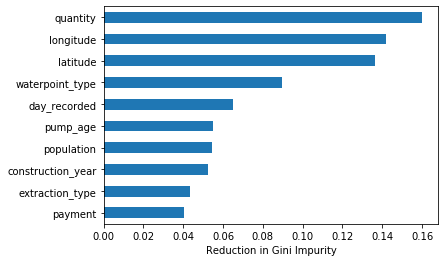

In [132]:
bestimator = model_rfrs.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

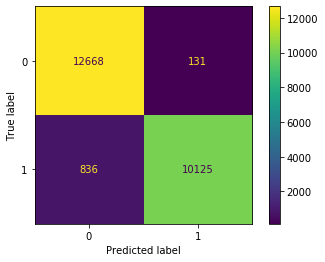

In [133]:
plot_confusion_matrix(
    model_rfrs,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)

In [134]:
print(classification_report(y_val,
                      model_rf.predict(X_val),
                      target_names =['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.78      0.89      0.83     12799
    needs repair       0.84      0.72      0.77     10961

        accuracy                           0.81     23760
       macro avg       0.81      0.80      0.80     23760
    weighted avg       0.81      0.81      0.81     23760



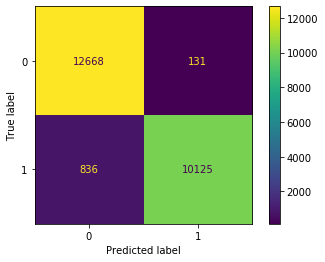

In [135]:
plot_confusion_matrix(
    model_rfgs,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)

In [136]:
print(classification_report(y_val,
                      model_rf.predict(X_val),
                      target_names =['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.78      0.89      0.83     12799
    needs repair       0.84      0.72      0.77     10961

        accuracy                           0.81     23760
       macro avg       0.81      0.80      0.80     23760
    weighted avg       0.81      0.81      0.81     23760



In [137]:
model_rfgs.predict(X_test)

array([0, 0, 1, ..., 1, 0, 1])

In [138]:
prediction = pd.DataFrame(data=model_rfrs.predict(X_test), index=X_test.index)

In [139]:
prediction.columns = ['status_group']

In [140]:
prediction

,status_group
id,
454.0,0
510.0,0
14146.0,1
47410.0,1
1288.0,1
...,...
68525.0,0
11980.0,0
35778.0,1


In [141]:
prediction.dtypes

status_group    int64
dtype: object

In [142]:
prediction.to_csv('OTTOLINO_WATER_PUMP_CHALLENGE.csv')

In [143]:
from google.colab import files
files.download("OTTOLINO_WATER_PUMP_CHALLENGE.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

I merged my two training CSV's, thoroughly examined the data and then wrangled both the train and test data the exact same. There after, I experimented with a few models and picked the randomforestclassifier after running it through a RandomizedSearchCV. Once I did that, I saw that my confusion matrix was very accurate to verify my model was indeed the correct choice.